In [1]:
import nltk
nltk.download('punkt_tab')
import os
import random
nltk.download('punkt')
import pandas as pd
import numpy as np
import torch
from collections import defaultdict
from sklearn.svm import SVC
import json
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
database = pd.read_excel('train_4452.xlsx')
database.tail(10)

,Unnamed: 0,title,body,date,tags,source,target
4442,4443,no title,Такой вот был позитивный сентимент вокруг акци...,2021-11-22 13:55:28+00:00,сбер,https://t.me/MarketDumki,0
4443,4444,no title,"По Газпрому похожая ситуация сегодня, что и в ...",2021-11-22 14:17:18+00:00,газпром,https://t.me/MarketDumki,-1
4444,4445,no title,"Акции Газпрома хоть и снижаются сегодня на 3%,...",2021-11-26 13:12:44+00:00,газпром,https://t.me/MarketDumki,0
4445,4446,no title,Еще в пятницу на падении рынка была видна поку...,2021-11-29 17:18:50+00:00,газпром,https://t.me/MarketDumki,1
4446,4447,no title,"Оставлю скрин на память. В ""стакане"" Газпрома ...",2021-12-14 04:40:12+00:00,газпром,https://t.me/MarketDumki,-1
4447,4448,no title,Красноречивые обороты сегодня в Сбере. 72 млрд...,2022-01-14 14:03:01+00:00,газпром,https://t.me/MarketDumki,0
4448,4449,no title,​​По Сберу сформировался очень сильный уровень...,2022-01-17 19:56:42+00:00,сбер,https://t.me/MarketDumki,0
4449,4450,no title,"​​Чем дальше в лес, тем больше дров! Сегодня о...",2022-01-18 19:19:44+00:00,сбер,https://t.me/MarketDumki,-1
4450,4451,no title,На протяжении многих лет не один раз на рынке ...,2022-02-25 08:34:58+00:00,сбер,https://t.me/MarketDumki,-1
4451,4452,no title,"На фоне того, сколько сейчас стОят акции Сбера...",2022-03-01 10:35:00+00:00,сбер,https://t.me/MarketDumki,-1


In the dataset the disclamers of the souces entities , and not needed quater marks are noticed . So they are deleted. Words and punctuation were saved. We also preserve the case of the source text

In [3]:
def preprocess(s):
    # function for text clearning
    s=s.replace('no title','')
    s=s.replace('no tags','')
    s=s.replace('[]','')
    s=s.split('$$$ БКС Мир инвестиций $$$ Инвестировать легче вместе')[0]
    s=s.replace('$$$','.')
    s=re.sub('\s*"','',s)
    s=s.replace('#','')
    s=s.replace(' • ',', ')
    return s


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(database, test_size=0.2, random_state=42)

In [5]:
train['text_extraction'] = train.title + ' ' + train.body + ' ' + train.tags
train['text_extraction_cleaned']= train.text_extraction.map(preprocess)
train['text_extraction_cleaned'][0]

" Самолет (SMLT) в 4кв2023 собирается побить рекорд 3кв. Менеджмент подтверждает цель в 1 600 тыс. кв. м продаж за весь 2023 год. аналитика факты Видимо, менеджмент видит уже по октябрьским цифрам, что даже после роста ключевой ставки продажи на первичке идут хорошо. Первичный рынок, особенно массовый сегмент, на котором работает Самолет — бенефициар программ льготной ипотеки. Цель на год 1600 кв.м.:, по итогам 9 месяцев есть 973 тыс. кв. м., консолидация МИЦ даст примерно 100 тыс. кв. м, таким образом, продажи Самолёта без МИЦ в 4 квартале могут составить порядка 527 тыс. кв. м - на 25% больше, чем в рекордном 3кв2023. ['аналитика', 'факты']"

In [6]:
train['text_extraction_cleaned'][0]

" Самолет (SMLT) в 4кв2023 собирается побить рекорд 3кв. Менеджмент подтверждает цель в 1 600 тыс. кв. м продаж за весь 2023 год. аналитика факты Видимо, менеджмент видит уже по октябрьским цифрам, что даже после роста ключевой ставки продажи на первичке идут хорошо. Первичный рынок, особенно массовый сегмент, на котором работает Самолет — бенефициар программ льготной ипотеки. Цель на год 1600 кв.м.:, по итогам 9 месяцев есть 973 тыс. кв. м., консолидация МИЦ даст примерно 100 тыс. кв. м, таким образом, продажи Самолёта без МИЦ в 4 квартале могут составить порядка 527 тыс. кв. м - на 25% больше, чем в рекордном 3кв2023. ['аналитика', 'факты']"

## Dataset analysis 

Basic statistics :

In [13]:
def words(i):
    # a function for splitting text into words
    regex = re.compile(r'[А-Яа-яA-zёЁ-]+')
    i= " ".join(regex.findall(i))
    tokens=word_tokenize(i.lower())
    return tokens

In [14]:
train['tokens'] = train.text_extraction_cleaned.map(words)


In [15]:
example_number = train.shape[0]


mean_length_text_extract=[]
for i in train.tokens:
    mean_length_text_extract.append(len(i))
mean_length_text_extract=np.mean(mean_length_text_extract)

number_unique_words=set()
for i in train.tokens:
    for j in i:
        number_unique_words.add(j)
number_unique_words=len(number_unique_words)

print('Checking the number of missing values : ' )
print(f'Number of missing values  in text_extraction: {train.text_extraction_cleaned.isnull().sum()}',f'Number of missing values in assessment of tonality : {train.target.isnull().sum()}','',sep='\n')
print(f'Number of examples in dataset: {example_number}','',sep='\n' )

print(f'Mean length of text_extraction: {round(mean_length_text_extract,0)}','',sep='\n')

print(f'Number of unique words : {number_unique_words}')

Checking the number of missing values : 
Number of missing values  in text_extraction: 0
Number of missing values in assessment of tonality : 0

Number of examples in dataset: 3561

Mean length of text_extraction: 73.0

Number of unique words : 30615


Target column analysis

In [12]:
def year_extraction(s):
    # function for year extraction from the date column
    if type(s) == int:
       s=str(s)
    else:
       s=s.split('-')[0]
    return s

In [13]:
train['year']= train.date.map(year_extraction)
train['year'].unique()

array(['2022', '2020', '2019', '2023', '2021', '2024', '2017', '2015',
       '2018', '2012', '2016', '2011', '2013'], dtype=object)

In [14]:
class_distribution =  train.target.value_counts()
print(f'Class_distribution: {class_distribution}','',sep='\n' )

Class_distribution: target
 1    1348
 0    1335
-1     878
Name: count, dtype: int64



Text(0.5, 1.0, 'Distirbution of the target variable')

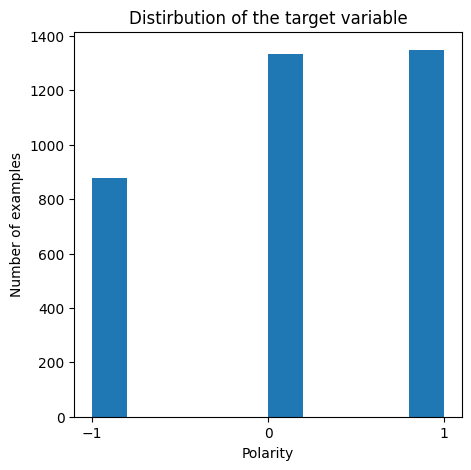

In [15]:
plt.figure(figsize=(5, 5))
train.target.plot.hist()
plt.ylabel('Number of examples')
plt.xlabel('Polarity')
plt.xticks(np.arange(-1,2,1))
plt.title('Distirbution of the target variable')


In [16]:
train.pivot_table(index='year', columns ='target',aggfunc={'target':'count'})

target              
target     -1      0      1
year                       
2011      NaN    NaN    1.0
2012      NaN    2.0    2.0
2013      NaN    4.0    NaN
2015      NaN    7.0    3.0
2016      2.0    1.0    2.0
2017      2.0    6.0    6.0
2018     26.0   34.0   34.0
2019     51.0  118.0   85.0
2020    122.0  179.0  207.0
2021    133.0  306.0  323.0
2022    328.0  373.0  404.0
2023     88.0  150.0  134.0
2024    126.0  155.0  147.0

In [17]:
train.year.value_counts().sort_index(ascending=True)

,count
year,
2011,1
2012,4
2013,4
2015,10
2016,5
2017,14
2018,94
2019,254
2020,508


 ## 1. Feature-based approach 

In [18]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [19]:
def get_sentence_embedding_bert(text, bert_model):
    # getting sentence embeddings from BERT model
    tokens = tokenizer(text,add_special_tokens = True, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    last_hidden_state = outputs.last_hidden_state
    return last_hidden_state[:, 0, :].cpu().numpy()

In [7]:
# preparing train dataset to embedding extraction
sentences_train = train.text_extraction_cleaned.values
labels_train = train.target.values
sentences_train[1]

' ВТБ, ао (VTBR) ПОКУПАТЬ Инвестиционный горизонт 2-6 мес. Цена входа 0,034 руб. Цель 0,039 руб. Потенциальная доходность на сделку 14,7% Объём входа 16,2% Стоп приказ 0,0319 руб. Бумага торгуется в восходящем тренде, встретив сопротивление в районе 0,037 р. Мы рекомендуем открывать длинные позиции на уровне 0,034 р., при откате от текущего уровня в 0,035 р. При покупке на 16,2% от портфеля и выставлении стоп заявки на 0,0319 р., риск на портфель составит 1%. Соотношение прибыль/риск составляет 2,38. Чистая прибыль ВТБ за первый квартал составила 38,9 млрд. рублей, снизившись на 6,7 млрд. рублей по сравнению с аналогичным периодом прошлого года. Основным негативным фактором послужила переоценка непрофильных активов банка. Прим этом чистые комиссионные доходы за первый квартал выросли на 48,1%. Одним из важных пунктов стратегии банка является повышение уровня цифровизации бизнеса, что окажет положительное влияние на операционную эффективность. Смотрите также: Macy’s Inc. (М) ПОКУПАТЬhtt

In [8]:
# preparing test dataset to embedding extraction
test['text_extraction'] = test.title + ' ' + test.body + ' ' + test.tags
test['text_extraction_cleaned']= test.text_extraction.map(preprocess)


In [9]:
sentences_test = test.text_extraction_cleaned.values
labels_test = test.target.values
sentences_test[0]

' СД ТМК одобрил размещение замещающих облигаций '

In [23]:
sent_embeddings_train = []
for text in sentences_train:
    sentence_embedding = get_sentence_embedding_bert(text, bert_model)
    sent_embeddings_train.append(sentence_embedding)


sent_embeddings_test = []
for text in sentences_test:
    sentence_embedding = get_sentence_embedding_bert(text, bert_model)
    sent_embeddings_test.append(sentence_embedding)



In [24]:
sent_embeddings_train_list=[]
for i in range(len(sent_embeddings_train)):
     sent_embeddings_train_list.append(sent_embeddings_train[i][0])


sent_embeddings_test_list=[]
for i in range(len(sent_embeddings_test)):
     sent_embeddings_test_list.append(sent_embeddings_test[i][0])



t-SNE (t-Distributed Stochastic Neighbor Embedding) is a widely used dimensionality reduction technique for visualizing high-dimensional data. While t-SNE is primarily used for visualization, it can also be used to generate embeddings. The process involves applying t-SNE to reduce the dimensionality of the data and obtaining a lower-dimensional embedding that captures the inherent structure of the original high-dimensional data.

In [25]:
# visualization of embeddings for train set
from sklearn.manifold import TSNE
import plotly.express as px

sent_embeddings_train_2D = np.array([emb[0] for emb in sent_embeddings_train])
tsne = TSNE(n_components=2,random_state=42,perplexity=(example_number-1))
reduced_embeddings = tsne.fit_transform(sent_embeddings_train_2D)

df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['label'] = labels_train  # При условии, что есть метки

# Создание точечного графика
fig = px.scatter(df, x='x', y='y', color='label', title=f't-SNE Visualization of BERT Embeddings (perplexity={(example_number-1)})')
fig.show()

In [26]:
# visualization of embeddings for train set
from sklearn.manifold import TSNE
import plotly.express as px

sent_embeddings_train_2D = np.array([emb[0] for emb in sent_embeddings_train])
tsne = TSNE(n_components=2,random_state=42,perplexity=(example_number-1)/2)
reduced_embeddings = tsne.fit_transform(sent_embeddings_train_2D)

df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['label'] = labels_train  # При условии, что есть метки

# Создание точечного графика
fig = px.scatter(df, x='x', y='y', color='label', title=f't-SNE Visualization of BERT Embeddings (perplexity={(example_number-1)/2})')
fig.show()

SVM:

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer


SVM=Pipeline([
    ('normalization', Normalizer()),
    ('SVC', SVC())])


param_grid = {
    'SVC__C': [0.1,1,5,10,20],
    'SVC__decision_function_shape': ['ovr','ovo'],
    'SVC__gamma': ['scale', 'auto'],
    'SVC__kernel': ['poly', 'rbf','linear' ,'sigmoid' ] }

grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=3, scoring='accuracy',n_jobs=-1,error_score='raise')
grid.fit(np.array(sent_embeddings_train_list), labels_train)

print("Best estimator:'\n",grid.best_score_)
print("Best parameters\n",grid.best_estimator_.named_steps['SVC'])


Best estimator:'
 0.528784049424319
Best parameters
 SVC(C=5, kernel='poly')


In [28]:
SVM=Pipeline([
    ('normalization', Normalizer()),
    ('SVC', grid.best_estimator_.named_steps['SVC'])])

SVM.fit(np.array(sent_embeddings_train_list),labels_train)
y_pred=SVM.predict(np.array(sent_embeddings_test_list))

print('Accuracy( with Norm): ', round(accuracy_score(labels_test, y_pred),2))
print('F1 (with Norm): ', round(f1_score(labels_test, y_pred, average = 'macro'),2))


Accuracy( with Norm):  0.56
F1 (with Norm):  0.55


In [29]:
from imblearn.over_sampling import ADASYN

adsin=ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=13)
X_resampled_train,y_resampled_train = adsin.fit_resample(sent_embeddings_train_list,labels_train )

SVM=Pipeline([
    ('normalization', Normalizer()),
    ('SVC', grid.best_estimator_.named_steps['SVC'])])

SVM.fit(X_resampled_train,y_resampled_train)
y_pred=SVM.predict(sent_embeddings_test_list)

print('Accuracy( with ADASYN+Norm): ', round(accuracy_score(labels_test, y_pred),2))
print('F1 (with ADASYN+Norm): ', round(f1_score(labels_test, y_pred, average = 'macro'),2))

Accuracy( with ADASYN+Norm):  0.54
F1 (with ADASYN+Norm):  0.54


SVM default:

In [30]:
SVM=SVC()

SVM.fit(np.array(sent_embeddings_train_list),labels_train)
y_pred=SVM.predict(np.array(sent_embeddings_test_list))

print('Accuracy: ', round(accuracy_score(labels_test, y_pred),2))
print('F1:', round(f1_score(labels_test, y_pred, average = 'macro'),2))

Accuracy:  0.57
F1: 0.52


SVM best parameters:

In [31]:
SVM= grid.best_estimator_.named_steps['SVC']

SVM.fit(np.array(sent_embeddings_train_list),labels_train)
y_pred=SVM.predict(np.array(sent_embeddings_test_list))

print('Accuracy: ', round(accuracy_score(labels_test, y_pred),2))
print('F1:', round(f1_score(labels_test, y_pred, average = 'macro'),2))

Accuracy:  0.56
F1: 0.55


RandomForest:

In [32]:
from sklearn.ensemble import RandomForestClassifier

RFC=Pipeline([
    ('normalization', Normalizer()),
    ('RFC', RandomForestClassifier())])


param_grid = {
    'RFC__n_estimators': [30,50,100,500],
    'RFC__max_depth': [10,20,50,100],
    'RFC__criterion': ['entropy','gini'],
    'RFC__min_samples_split': [2,5,10,15]}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=3, scoring='accuracy',n_jobs=-1,error_score='raise')
grid.fit(np.array(sent_embeddings_train_list), labels_train)

print("Best estimator:'\n",grid.best_score_)
print("Best parameters\n",grid.best_estimator_.named_steps['RFC'])

Best estimator:'
 0.5226060095478797
Best parameters
 RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=500)


In [33]:
adsin=ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=13)
X_resampled_train,y_resampled_train = adsin.fit_resample(sent_embeddings_train_list,labels_train )

RFC=Pipeline([
    ('normalization', Normalizer()),
    ('RFC',grid.best_estimator_.named_steps['RFC'])])

RFC.fit(X_resampled_train,y_resampled_train)
y_pred=SVM.predict(np.array(sent_embeddings_test_list))

print('Accuracy( with ADASYN+Norm): ', round(accuracy_score(labels_test, y_pred),2))
print('F1 (with ADASYN+Norm): ', round(f1_score(labels_test, y_pred, average = 'macro'),2))

Accuracy( with ADASYN+Norm):  0.56
F1 (with ADASYN+Norm):  0.55


In [34]:
RFC=Pipeline([
    ('normalization', Normalizer()),
    ('RFC', grid.best_estimator_.named_steps['RFC'])])

RFC.fit(np.array(sent_embeddings_train_list),labels_train)
y_pred=SVM.predict(np.array(sent_embeddings_test_list))

print('Accuracy( with Norm): ', round(accuracy_score(labels_test, y_pred),2))
print('F1 (with Norm): ', round(f1_score(labels_test, y_pred, average = 'macro'),2))

Accuracy( with Norm):  0.56
F1 (with Norm):  0.55


In [35]:
RFC=grid.best_estimator_.named_steps['RFC']

RFC.fit(np.array(sent_embeddings_train_list),labels_train)
y_pred=SVM.predict(np.array(sent_embeddings_test_list))

print('Accuracy: ', round(accuracy_score(labels_test, y_pred),2))
print('F1 : ', round(f1_score(labels_test, y_pred, average = 'macro'),2))

Accuracy:  0.56
F1 :  0.55


## 2.BERT  fine-tuning approach

For the task we take BertForSequenceClassification. It's a base  BERT model with a classifier head to perform sentence or document-level classification.The BertForSequenceClassification effectively takes the BertModel and builds a classification layer on top plus some additional elements such as adding the right activation and loss function

Support Functions:

In [10]:
def flatten_accuracy(preds, labels):
    # function that calculates accuracy for Bert model
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flatten_f1_score(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')


Data preparation:

In [11]:
# import tokenizer for BERT model
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [16]:
batch_size = 64
max_length=round(mean_length_text_extract,0)
max_length=int(max_length)
max_length

73

In [17]:
# prepare labels for the model
def index_change_labels(s):
   # a function that changes the value of labels to indexes that are understandable to BertForClassification model
    if s == 1 :
       s=0
    elif s== 0:
       s=1
    elif s== -1:
       s=2
    return s

train['index_BERT']= train.target.map(index_change_labels)
labels_train= train.index_BERT.values
labels_train

array([2, 0, 2, ..., 0, 2, 2])

In [18]:
input_ids = []
attention_masks = []

for sent in sentences_train:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_train)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
print('Original: ', sentences_train[3])
print('Token IDs:', input_ids[3])

Original:   Обзор финансовых показателей Алросы 2 кв2019 Автор подробно разобрал отчет и ответил на вопросстоит ли покупать прямо сейчас? https://smart-lab.ru/blog/556933.php алроса
Token IDs: tensor([   101,  18890,  48645,    561,  13139, 109751,  12861,  45899,  13594,
         21859,  26657,  44181,  10292,    123,  69055,  22650,  54055,  28433,
         11429,  14315,  40671,  17257,  33276,  31326,  10332,  54697,    549,
         83415,  13460,  10122,  58099,  41054,  15811,  33190,  10297,  86613,
         18235,  75552,  61149,    136,  14120,    131,    120,    120,  98507,
           118,  93409,    119,  13483,    120,  31907,    120,  54919,  11373,
         69646,    119,  13417,  21720,  44181,  10179,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


In [20]:
# devide to train and validation set in proportion 90% vs 10%
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)


train_size = int(0.9 * len(dataset))
dev_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, dev_size])

print(f'{train_size} training samples')
print(f'{dev_size} validation samples')

3204 training samples
357 validation samples


In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,drop_last=True
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size,drop_last=True
        )


In [22]:
# preparing data for test set
test['index_BERT']= test.target.map(index_change_labels)
labels_test= test.index_BERT.values
labels_test


input_ids = []
attention_masks = []

for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)


prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Model inizialization:

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels = 3,output_attentions = False,output_hidden_states = False)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# inicialization of the model
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    model.cuda()
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [25]:
# Set an optimizer

def set_optimizer(lr = 2e-5, dft_rate=1.2, correct_bias=True, eps = 1e-8, discriminative= True):
     
      no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight'] 


      if discriminative == True:

                encoder_params = []
                for i in range(12):
                    encoder_decay = {
                        'params': [p for n, p in list(model.bert.encoder.layer[i].named_parameters()) if
                                  not any(nd in n for nd in no_decay)],
                        'weight_decay': 0.01,
                        'lr': lr / (dft_rate ** (12 - i))}
                    encoder_nodecay = {
                        'params': [p for n, p in list(model.bert.encoder.layer[i].named_parameters()) if
                                  any(nd in n for nd in no_decay)],
                        'weight_decay': 0.0,
                        'lr': lr / (dft_rate ** (12 - i))}
                    encoder_params.append(encoder_decay)
                    encoder_params.append(encoder_nodecay)

                optimizer_grouped_parameters = [
                    {'params': [p for n, p in list(model.bert.embeddings.named_parameters()) if
                                not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01,
                    'lr': lr / (dft_rate ** 13)},
                    {'params': [p for n, p in list(model.bert.embeddings.named_parameters()) if
                                any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0,
                    'lr': lr / (dft_rate ** 13)},
                    {'params': [p for n, p in list(model.bert.pooler.named_parameters()) if
                                not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01,
                    'lr': lr},
                    {'params': [p for n, p in list(model.bert.pooler.named_parameters()) if
                                any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0,
                    'lr': lr},
                    {'params': [p for n, p in list(model.classifier.named_parameters()) if
                                not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01,
                    'lr': lr},
                    {'params': [p for n, p in list(model.classifier.named_parameters()) if any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0,
                    'lr': lr}]

                optimizer_grouped_parameters.extend(encoder_params)


      else:
                param_optimizer = list(model.named_parameters())

                optimizer_grouped_parameters = [
                    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01},
                    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
                ]

      return AdamW(optimizer_grouped_parameters,
                    lr=lr,
                    eps = eps,
                    correct_bias=correct_bias)

In [26]:
from transformers import get_linear_schedule_with_warmup

# set sheduler

def set_scheduler (train_dataloader,epochs,optimizer, STLR = True) :
    total_steps = len(train_dataloader) * epochs
    if STLR == True:
       warm_up_proportion=0.1
       num_warmup_steps = int(float(total_steps) * warm_up_proportion)
    else:
       num_warmup_steps=0
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps,num_training_steps = total_steps)
    return scheduler

In [27]:
from sklearn.metrics import accuracy_score,f1_score

# training the model
import random

def train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=4,seed_val=42,gradual_unfreeze=True,encoder_no=1):

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    training_stats = []
    i=0
    step_number = len(train_dataloader)
    for epoch_i in range(0, epochs):
        print(f'Epoch {epoch_i} : ')
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            # graduate unfrizing
            if (gradual_unfreeze and i == 0):
                for param in model.bert.parameters():
                    param.requires_grad = False
            if (step % (step_number // 3)) == 0:
                i += 1
            if (gradual_unfreeze and i > 1 and i < encoder_no):
                for k in range(i - 1):
                    try:
                        for param in model.bert.encoder.layer[encoder_no - 1 - k].parameters():
                            param.requires_grad = True
                    except:
                        pass
            if (gradual_unfreeze and i > encoder_no + 1):
                for param in model.bert.embeddings.parameters():
                    param.requires_grad = True

            #main loop
            if step % 10 == 0 and not step == 0:
                # Report progress.
                print(' Epoch {:>5,}  Batch {:>5,}  of  {:>5,}.   '.format(epoch_i,step, len(train_dataloader)))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels=batch[2].to(device)

            model.zero_grad()


            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)
            loss = output[0]
            logits = output[1]


            total_train_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()


        avg_train_loss = total_train_loss / len(train_dataloader)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))



        print("")
        print("Validation:")

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        total_f1 =0
        nb_eval_steps = 0

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels=batch[2].to(device)

            with torch.no_grad():
                output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)
                loss = output[0]
                logits = output[1]



            total_eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flatten_accuracy(logits, label_ids)
            total_f1+=flatten_f1_score(logits, label_ids)

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))

        # Calculate the average F1 over all of the batches.
        avg_val_f1 = total_f1 / len(validation_dataloader)

        print("  Validation F1: {0:.2f}".format(avg_val_f1),'',sep='\n')

        training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Train. Loss': round(avg_train_loss,2),
            'Valid. Loss': round(avg_val_loss,2),
            'Valid. Accur.': round(avg_val_accuracy,2),
            'Valid. F1': round(avg_val_f1,2),
            'Number_of_epochs': epochs,
        }
        )

    return model,training_stats


In [28]:
# Prediction on the Test set
def evaluation(model,prediction_dataloader):

      valid_stats=[]
      model.eval()

      predictions , true_labels = [], []

      # Predict
      for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

      from sklearn.metrics import accuracy_score

      flat_predictions = np.concatenate(predictions, axis=0)
      flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
      flat_true_labels = np.concatenate(true_labels, axis=0)

      valid_stats.append(
        {
            'Accuracy': round(accuracy_score(flat_true_labels, flat_predictions),2),
            'F1 Score': round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)

        }
        )

      print("Metrics for Test set: ")
      print("Accuracy: ", round(accuracy_score(flat_true_labels, flat_predictions),2))
      print("F1 Score: ", round(f1_score(flat_true_labels, flat_predictions, average='macro'),2),'',sep='\n')

      return valid_stats

In [29]:

# experiments


for epochs in [2,3,6]:
      print ('Number of epochs :',epochs)

      # domain train model (with decay)
      name='model with Decay'

      optimizer = set_optimizer(lr = 2e-5,eps = 1e-8, discriminative= False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = False)

      model_D, result_D = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=False)
      mertics=evaluation(model=model_D,prediction_dataloader=prediction_dataloader)

      df_stats1 = pd.DataFrame (data=result_D)

      df_stats1['model']=name

      df_stats1_1 = pd.DataFrame (data=mertics)
      df_stats1_1['model']=name



      # domain train model (with decay, STLR )

      name='model with Decay,SLTR'

      optimizer = set_optimizer(lr = 2e-5,eps = 1e-8, discriminative= False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = True)

      model_D_SLTR, result_D_SLTR = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=False)
      mertics=evaluation(model=model_D_SLTR,prediction_dataloader=prediction_dataloader)

      df_stats2 = pd.DataFrame (data=result_D_SLTR)

      df_stats2['model']=name

      df_stats2_1 = pd.DataFrame (data=mertics)
      df_stats2_1['model']=name


      # domain train model (with decay, STLR,GU(12) )

      name='model with Decay,SLTR,GU(12 layers)'

      optimizer = set_optimizer(lr = 2e-5,eps = 1e-8, discriminative= False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = True)

      model_D_SLTR_GU12, result_D_SLTR_GU12 = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=True,encoder_no=12)
      mertics=evaluation(model=model_D_SLTR_GU12,prediction_dataloader=prediction_dataloader)

      df_stats3 = pd.DataFrame (data=result_D_SLTR_GU12)

      df_stats3['model']=name

      df_stats3_1 = pd.DataFrame (data=mertics)
      df_stats3_1['model']=name


      # domain train model (with decay, STLR,GU(6) )

      name='model with Decay,SLTR,GU(6 layers)'

      optimizer = set_optimizer(lr = 2e-5,eps = 1e-8, discriminative= False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = True)

      model_D_SLTR_GU6, result_D_SLTR_GU6 = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=True,encoder_no=6)
      mertics=evaluation(model=model_D_SLTR_GU6,prediction_dataloader=prediction_dataloader)

      df_stats4 = pd.DataFrame (data=result_D_SLTR_GU6)

      df_stats4['model']=name

      df_stats4_1 = pd.DataFrame (data=mertics)
      df_stats4_1['model']=name


      # domain train model (with decay, STLR,GU(12),DFT )

      name='model with Decay,SLTR,GU(12 layers),DFT'

      optimizer = set_optimizer(lr = 2e-5,dft_rate=1.5,eps = 1e-8, discriminative= True, correct_bias=False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = True)

      model_D_SLTR_GU12_DFT, result_D_SLTR_GU12_DFT = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=True,encoder_no=12)
      mertics=evaluation(model=model_D_SLTR_GU12_DFT,prediction_dataloader=prediction_dataloader)

      df_stats5 = pd.DataFrame (data=result_D_SLTR_GU12_DFT)

      df_stats5['model']=name

      df_stats5_1 = pd.DataFrame (data=mertics)
      df_stats5_1['model']=name



      # domain train model (with decay, STLR,GU(6),DFT )

      name='model with Decay,SLTR,GU(6 layers),DFT'

      optimizer = set_optimizer(lr = 2e-5,dft_rate=1.5,eps = 1e-8, discriminative= True, correct_bias=False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = True)

      model_D_SLTR_GU6_DFT, result_D_SLTR_GU6_DFT = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=True,encoder_no=6)
      mertics=evaluation(model=model_D_SLTR_GU6_DFT,prediction_dataloader=prediction_dataloader)

      df_stats6 = pd.DataFrame (data=result_D_SLTR_GU6_DFT)

      df_stats6['model']=name

      df_stats6_1 = pd.DataFrame (data=mertics)
      df_stats6_1['model']=name


      # vanilla model

      total_steps = len(train_dataloader) * epochs

      name='vanilla model'

      optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = total_steps)

      model_vanilla, result_vanilla = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=False)
      mertics=evaluation(model=model_vanilla,prediction_dataloader=prediction_dataloader)

      df_stats7 = pd.DataFrame (data=result_vanilla)

      df_stats7['model']=name

      df_stats7_1 = pd.DataFrame (data=mertics)
      df_stats7_1['model']=name


      df_train= pd.concat([df_stats1,df_stats2,df_stats3,df_stats4,df_stats5,df_stats6,df_stats7])
      df_test= pd.concat([df_stats1_1,df_stats2_1,df_stats3_1,df_stats4_1,df_stats5_1,df_stats6_1,df_stats7_1])

      if epochs==2:
         statistica_train=df_train
         statistica_test=df_test

statistica_train=pd.concat([statistica_train,df_train])
statistica_test=pd.concat([statistica_test,df_test])

statistica_train.to_excel('data_exp1_train3_1.5_64_4452.xlsx',index=False)
statistica_test.to_excel('data_exp1_test3_1.5_64_4452.xlsx',index=False)


Number of epochs : 2
Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 1.04

Validation:
  Accuracy: 0.61
  Validation Loss: 0.90
  Validation F1: 0.61

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.89

Validation:
  Accuracy: 0.62
  Validation Loss: 0.84
  Validation F1: 0.61

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.6

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.80

Validation:
  Accuracy: 0.64
  Validation Loss: 0.80
  Validation F1: 0.64

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.67

Validation:
  Accuracy: 0.64
  Validation Loss: 0.84
  Validation F1: 0.63

Metrics for Test set: 
Accuracy:  0.62
F1 Score: 
0.62

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.50

Validation:
  Accuracy: 0.64
  Validation Loss: 0.88
  Validation F1: 0.64

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.55

Validation:
  Accuracy: 0.63
  Validation Loss: 0.91
  Validation F1: 0.62

Metrics for Test set: 
Accuracy:  0.63
F1 Score: 
0.62

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.44

Validation:
  Accuracy: 0.62
  Validation Loss: 0.91
  Validation F1: 0.62

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.50

Validation:
  Accuracy: 0.62
  Validation Loss: 0.93
  Validation F1: 0.62

Metrics for Test set: 
Accuracy:  0.63
F1 Score: 
0.62

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.37

Validation:
  Accuracy: 0.60
  Validation Loss: 1.13
  Validation F1: 0.60

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.44

Validation:
  Accuracy: 0.60
  Validation Loss: 1.17
  Validation F1: 0.59

Metrics for Test set: 
Accuracy:  0.62
F1 Score: 
0.61

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.28

Validation:
  Accuracy: 0.61
  Validation Loss: 1.18
  Validation F1: 0.61

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.38

Validation:
  Accuracy: 0.60
  Validation Loss: 1.21
  Validation F1: 0.60

Metrics for Test set: 
Accuracy:  0.62
F1 Score: 
0.62

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.29

Validation:
  Accuracy: 0.61
  Validation Loss: 1.17
  Validation F1: 0.61

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.33

Validation:
  Accuracy: 0.58
  Validation Loss: 1.24
  Validation F1: 0.58

Metrics for Test set: 
Accuracy:  0.62
F1 Score: 
0.62

Number of epochs : 3
Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.15

Validation:
  Accuracy: 0.60
  Validation Loss: 1.32
  Validation F1: 0.60

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.28

Validation:
  Accuracy: 0.59
  Validation Loss: 1.42
  Validation F1: 0.59

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.44

Validation:
  Accuracy: 0.59
  Validation Loss: 1.37
  Validation F1: 0.59

Metrics for Test set: 
Accuracy:  0.61
F1 Score: 
0.61

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.08

Validation:
  Accuracy: 0.61
  Validation Loss: 1.44
  Validation F1: 0.61

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.16

Validation:
  Accuracy: 0.59
  Validation Loss: 1.52
  Validation F1: 0.59

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.31

Validation:
  Accuracy: 0.59
  Validation Loss: 1.48
  Validation F1: 0.59

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.6

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.04

Validation:
  Accuracy: 0.58
  Validation Loss: 1.69
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.10

Validation:
  Accuracy: 0.56
  Validation Loss: 1.85
  Validation F1: 0.56

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.24

Validation:
  Accuracy: 0.59
  Validation Loss: 1.76
  Validation F1: 0.59

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.6

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.57
  Validation Loss: 1.83
  Validation F1: 0.57

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.06

Validation:
  Accuracy: 0.59
  Validation Loss: 1.95
  Validation F1: 0.58

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.18

Validation:
  Accuracy: 0.59
  Validation Loss: 1.90
  Validation F1: 0.59

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.6

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.56
  Validation Loss: 2.23
  Validation F1: 0.56

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.06

Validation:
  Accuracy: 0.62
  Validation Loss: 2.31
  Validation F1: 0.62

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.18

Validation:
  Accuracy: 0.59
  Validation Loss: 2.43
  Validation F1: 0.59

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.6

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.02

Validation:
  Accuracy: 0.57
  Validation Loss: 2.57
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.02

Validation:
  Accuracy: 0.58
  Validation Loss: 2.62
  Validation F1: 0.58

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.15

Validation:
  Accuracy: 0.58
  Validation Loss: 2.60
  Validation F1: 0.58

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.6

Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.57
  Validation Loss: 2.60
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.58
  Validation Loss: 2.66
  Validation F1: 0.58

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.16

Validation:
  Accuracy: 0.58
  Validation Loss: 2.72
  Validation F1: 0.57

Metrics for Test set: 
Accuracy:  0.6
F1 Score: 
0.59

Number of epochs : 6
Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.02

Validation:
  Accuracy: 0.58
  Validation Loss: 2.81
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.56
  Validation Loss: 2.87
  Validation F1: 0.56

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.16

Validation:
  Accuracy: 0.58
  Validation Loss: 2.77
  Validation F1: 0.57

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.01

Validation:
  Accuracy: 0.60
  Validation Loss: 2.64
  Validation F1: 0.60

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.57
  Validation Loss: 2.74
  Validation F1: 0.57

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.08

Validation:
  Accuracy: 0.59
  Validation Loss: 2.67
  Validation F1: 0.59

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.01

Validation:
  Accuracy: 0.57
  Validation Loss: 2.70
  Validation F1: 0.56

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.01

Validation:
  Accuracy: 0.58
  Validation Loss: 2.89
  Validation F1: 0.58

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.05

Validation:
  Accuracy: 0.58
  Validation Loss: 2.85
  Validation F1: 0.58

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.00

Validation:
  Accuracy: 0.59
  Validation Loss: 2.82
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.01

Validation:
  Accuracy: 0.58
  Validation Loss: 2.92
  Validation F1: 0.58

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.04

Validation:
  Accuracy: 0.60
  Validation Loss: 2.94
  Validation F1: 0.60

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.00

Validation:
  Accuracy: 0.58
  Validation Loss: 3.37
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.01

Validation:
  Accuracy: 0.60
  Validation Loss: 3.67
  Validation F1: 0.60

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.02

Validation:
  Accuracy: 0.62
  Validation Loss: 3.58
  Validation F1: 0.62

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.00

Validation:
  Accuracy: 0.58
  Validation Loss: 3.89
  Validation F1: 0.58

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.00

Validation:
  Accuracy: 0.60
  Validation Loss: 3.92
  Validation F1: 0.59

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.00

Validation:
  Accuracy: 0.58
  Validation Loss: 4.13
  Validation F1: 0.57

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of     50.   
 Epoch     0  Batch    20  of     50.   
 Epoch     0  Batch    30  of     50.   
 Epoch     0  Batch    40  of     50.   

  Average training loss: 0.00

Validation:
  Accuracy: 0.58
  Validation Loss: 4.16
  Validation F1: 0.57

Epoch 1 : 
 Epoch     1  Batch    10  of     50.   
 Epoch     1  Batch    20  of     50.   
 Epoch     1  Batch    30  of     50.   
 Epoch     1  Batch    40  of     50.   

  Average training loss: 0.01

Validation:
  Accuracy: 0.59
  Validation Loss: 4.13
  Validation F1: 0.59

Epoch 2 : 
 Epoch     2  Batch    10  of     50.   
 Epoch     2  Batch    20  of     50.   
 Epoch     2  Batch    30  of     50.   
 Epoch     2  Batch    40  of     50.   

  Average training loss: 0.03

Validation:
  Accuracy: 0.60
  Validation Loss: 3.97
  Validation F1: 0.60

Epoch 3 : 
 Epoch     3  Batch    10  of     50.   
 Epoch     3  Batch    20  of     50.   
 Epoch     3  Batch    30  of     50.   
 Epoch     3  Batch    40  o